In [3]:
import pandas as pd
import numpy as np
from data_preprocessing import compressed_pickle, decompress_pickle
from fastai.tabular.all import *
import os

In [2]:
path = "../data/preprocessed/BikeRental_preprocessed.csv"
df = pd.read_csv("../data/preprocessed/BikeRental_preprocessed.csv", index_col=[0])
min_max = pd.read_csv("../data/preprocessed/cnt_min_max.csv")
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01 00:00:00,1.0,0.0,1,0,0.0,5,0.0,1.0,0.224490,0.81,0.0,0.015369
1,2011-01-01 01:00:00,1.0,0.0,1,1,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.039959
2,2011-01-01 02:00:00,1.0,0.0,1,2,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.031762
3,2011-01-01 03:00:00,1.0,0.0,1,3,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.012295
4,2011-01-01 04:00:00,1.0,0.0,1,4,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.000000


In [3]:
cat_names = ['season', 'yr', 'weathersit', "workingday", "holiday"]
cont_names = ['mnth', 'hr', 'weekday', 'temp', "windspeed", "hum"]
procs = [Categorify]

In [4]:
dls = TabularDataLoaders.from_df(df, path, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="cnt", bs=64)

In [5]:
split = 0.8
splits = (list(range(0,round(len(df)*split))),list(range(round(len(df)*split), len(df))))

In [6]:
to = TabularPandas(df, procs=[Categorify],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='cnt',
                   splits=splits)

In [7]:
dls = to.dataloaders(bs=64)

In [26]:
learn = tabular_learner(dls,
                        metrics=[R2Score(), ExplainedVariance()],
                       layers=[500,250])

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.00013182566908653826)

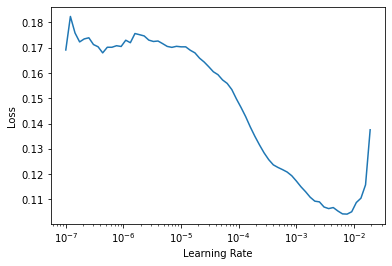

In [27]:
learn.lr_find()

In [17]:
try:
    learn.load('/fastai/fastai_learner')
    print("Model loaded!")
except FileNotFoundError:
    learn.fit_one_cycle(50)
    if not os.path.exists("/fastai"):
        os.makedirs("/fastai")
    learn.save('/fastai/fastai_learner')
    print("Model trained and saved!")

Model loaded!


In [71]:
train_df = df[:round(len(df)*0.8)].copy()
train_df.rename(columns={"cnt":"cnt_real"})
dl = learn.dls.test_dl(train_df)
y_train_preds = learn.get_preds(dl=dl)
y_train_preds = [y_train_preds[0][i].item() for i in range(0, len(y_train_preds[0]))]
Y_train_mean = train_df["cnt"].values.mean()
Y_train_meandev = sum((train_df["cnt"].values-Y_train_mean)**2)
Y_train_dev = sum((train_df["cnt"].values-y_train_preds)**2)
r2 = 1 - Y_train_dev/Y_train_meandev
print("R2 =", r2)

R2 = 0.9069887088056688


In [72]:
test_df = df[round(len(df)*0.8):].copy()
test_df.rename(columns={"cnt":"cnt_real"})
dl = learn.dls.test_dl(test_df)
y_test_preds = learn.get_preds(dl=dl)
y_test_preds = [y_test_preds[0][i].item() for i in range(0, len(y_test_preds[0]))]
Y_test_dev = sum((test_df["cnt"].values-y_test_preds)**2)
Y_test_mean = test_df["cnt"].values.mean()
Y_test_meandev = sum((test_df["cnt"].values-Y_test_mean)**2)
pseudor2 = 1 - Y_test_dev/Y_test_meandev
print("Pseudo-R2 =", pseudor2)

Pseudo-R2 = 0.8134570661152176


In [52]:
test_df = df[round(len(df)*0.8):].copy()
test_df.rename(columns={"cnt":"cnt_real"})
dl = learn.dls.test_dl(test_df)
preds = learn.get_preds(dl=dl)
test_df["cnt_pred"] = [preds[0][i].item() for i in range(0, len(preds[0]))]
test_df["cnt_norm"] = test_df["cnt"].apply(lambda x: x * (min_max["max"][0] - min_max["min"][0]) + min_max["min"][0])
test_df["cnt_pred_norm"] = test_df["cnt_pred"].apply(lambda x: round(x * (min_max["max"][0] - min_max["min"][0]) + min_max["min"][0]))

if not os.path.exists("./data/predictions"):
    os.makedirs("./data/predictions")

compressed_pickle("./data/predictions/fastai", test_df)

In [53]:
test_df

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,cnt_pred,cnt_norm,cnt_pred_norm
14035,2012-08-07 19:00:00,3.0,1.0,8,19,0.0,1,1.0,2.0,0.755102,0.66,0.122840,0.623975,0.698634,610.0,683.0
14036,2012-08-07 20:00:00,3.0,1.0,8,20,0.0,1,1.0,2.0,0.734694,0.70,0.157870,0.457992,0.516423,448.0,505.0
14037,2012-08-07 21:00:00,3.0,1.0,8,21,0.0,1,1.0,2.0,0.714286,0.74,0.000000,0.323770,0.310445,317.0,304.0
14038,2012-08-07 22:00:00,3.0,1.0,8,22,0.0,1,1.0,1.0,0.714286,0.74,0.122840,0.228484,0.260372,224.0,255.0
14039,2012-08-07 23:00:00,3.0,1.0,8,23,0.0,1,1.0,1.0,0.714286,0.79,0.000000,0.140369,0.176163,138.0,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2012-12-31 19:00:00,1.0,1.0,12,19,0.0,0,1.0,2.0,0.244898,0.60,0.193018,0.120902,0.238927,119.0,234.0
17540,2012-12-31 20:00:00,1.0,1.0,12,20,0.0,0,1.0,2.0,0.244898,0.60,0.193018,0.090164,0.160298,89.0,157.0
17541,2012-12-31 21:00:00,1.0,1.0,12,21,0.0,0,1.0,1.0,0.244898,0.60,0.193018,0.091189,0.120509,90.0,119.0
17542,2012-12-31 22:00:00,1.0,1.0,12,22,0.0,0,1.0,1.0,0.244898,0.56,0.157870,0.061475,0.094423,61.0,93.0
